In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

### 목표1: Bubble Chart를 활용, 질량과 FUR 을 비교하여 양품, 불량을 시각화한다.

## 데이터 불러오기

In [3]:
df = pd.read_csv('steel_date.csv')

In [5]:
steel = df


In [ ]:
steel.drop(columns='unnamed: 0', inplace=True)

In [6]:
steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         720 non-null    int64  
 1   PLATE_NO           720 non-null    object 
 2   ROLLING_DATE       720 non-null    object 
 3   SCALE              720 non-null    object 
 4   SPEC               720 non-null    object 
 5   STEEL_KIND         720 non-null    object 
 6   PT_THK             720 non-null    float64
 7   PT_WDTH            720 non-null    int64  
 8   PT_LTH             720 non-null    int64  
 9   PT_WGT             720 non-null    int64  
 10  FUR_NO             720 non-null    object 
 11  FUR_NO_ROW         720 non-null    int64  
 12  FUR_HZ_TEMP        720 non-null    int64  
 13  FUR_HZ_TIME        720 non-null    int64  
 14  FUR_SZ_TEMP        720 non-null    int64  
 15  FUR_SZ_TIME        720 non-null    int64  
 16  FUR_TIME           720 non

## 데이터 전처리

### 칼럼 소문자로 변환

In [7]:
#모든 칼럼 소문자로 변환

steel.rename(str.lower, axis='columns', inplace=True)

### 고유값이 2개인 칼럼 값 치환

In [8]:
#계산이 용이하도록 고유값이 2개인 SCALE과 HSB칼럼을 0과 1로 치환

steel['scale'] = steel['scale'].replace({'양품':1, '불량':0})
steel['hsb'] = steel['hsb'].replace({'적용':1, '미적용':0})

### 중복하는 칼럼 제거

In [9]:
#값이 정확히 일치하는 두 개의 칼럼이 있어 하나를 제거해주었다.

#'FUR_SZ_TEMP', 'FUR_EXTEMP' 칼럼이 정확히 일치하는지 확인
duplicate = steel[['fur_sz_temp','fur_extemp']].assign(duplicate_lambda=lambda x: (x['fur_sz_temp'] == x['fur_extemp']))

#print(test1.to_string())        #출력해보면 두 칼럼의 모든 항목을 비교하는 표를 확인할 수 있다.
print(duplicate['duplicate_lambda'].unique())      #lamda로 추출한 값에 True만 존재하기 때문에, 정확히 일치함을 확인

steel.drop(columns='fur_extemp', inplace=True)

[ True]


### 고유값 확인

In [10]:
#PLATE_NO는 생산된 철의 중복되지 않은 고유번호임을 알 수 있다.

plt_no_nunique = steel['plate_no'].nunique()
plt_no_count = steel['plate_no'].count()
print('plate_no 고유값은 ' + str(plt_no_nunique) + '개,\n' + 
      '데이터 수는' + str(plt_no_count) + '개 입니다.')

plate_no 고유값은 720개,
데이터 수는720개 입니다.


### 일단 전부 시각화

#### SPEC별 불량률 - Stacked bar 차트

In [11]:
#데이터프레임 추출
spec_1 = pd.Series(steel['spec'].unique())
spec_2 = pd.DataFrame()

for i in spec_1:
    yes = steel[(steel['spec'] == i) & (steel['scale'] == 1)]['scale'].count()
    no = steel[(steel['spec'] == i) & (steel['scale'] == 0)]['scale'].count()
    spec_2 = pd.concat([spec_2,pd.DataFrame([i, yes, no, yes + no]).T])
    
spec_2.reset_index(drop=True)
spec_2.columns = ['spec','1','0','sum']
spec_2.sort_values(by='sum', ascending=False, inplace=True)

In [12]:
spec_2.head(3)

,spec,1,0,sum
0,JS-SM490YB,49,35,84
0,LR-A,43,11,54
0,NV-A,34,14,48


In [ ]:
plt01 = steel.groupby('spec')[['scale']].count()
plt01.sort_values(by='scale', ascending=False, inplace=True)

In [ ]:
px.line(plt01, x=plt01.index, y='scale')

- 위 그래프 토대로 생산 수 10개 이상의 SPEC을 추려 분석
- 19개의 규격이 전체 생산량의 약 78%를 차지
- 19개에 대한 근거+(파이차트)

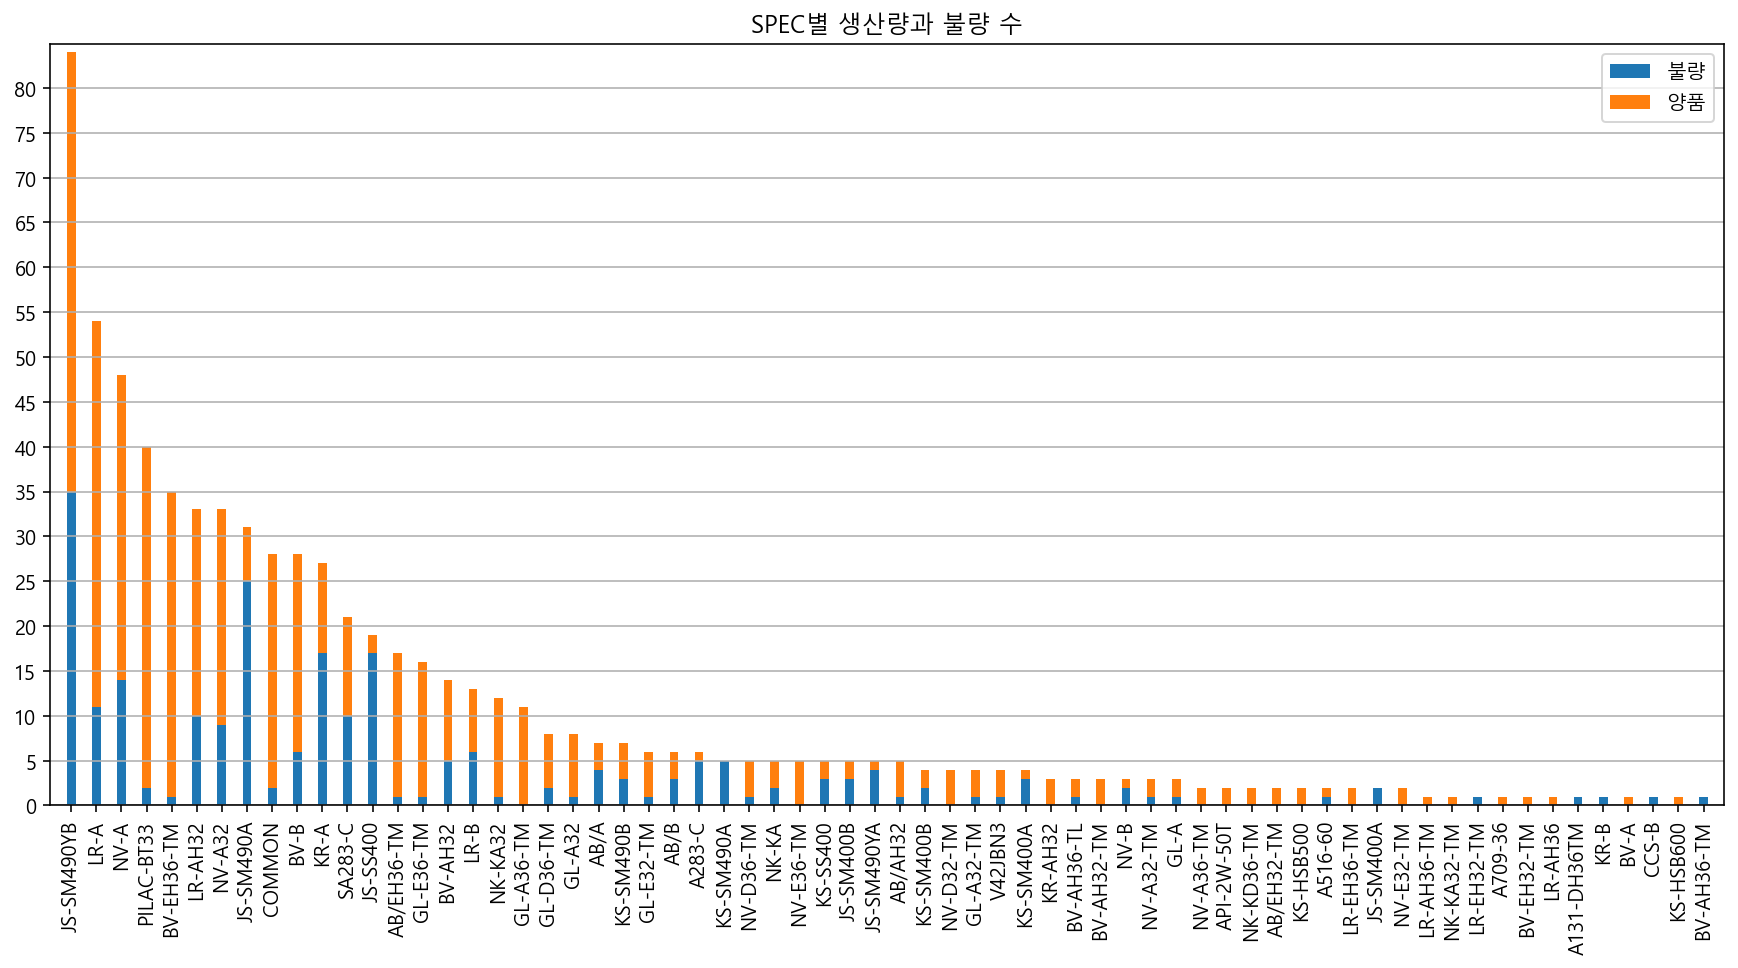

In [13]:
#Stacked Bar 차트

labels = spec_2['spec']
x1 = spec_2['0']
x2 = spec_2['1']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(labels, x1, width, label='불량')
ax.bar(labels, x2, width, bottom=x1, label='양품')
#ax.set_xticklabels(labels, rotation=45)

#ax.set_ylabel('Scores')
ax.set_title('SPEC별 생산량과 불량 수')
ax.legend()

plt.style.use('ggplot')
#plt.figure(figsize=(15,7))
#plt.bar(bc1_labels, bc1_values, width=0.7)
#plt.set_xlabel(fontsize=10)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 100, step=5))
plt.margins(0.01)
plt.grid(True, axis='y')
plt.show()

- 양품과 불량의 확률에 따라 두 그룹으로 나눈 뒤 분석하여 전체적인 불량율을 줄이는 분석이 목표
- 불량율의 기준은 PILAC-BT33 규격을 설정. 5% 미만을 목표로 진행


In [16]:
bt_01 = steel[steel['spec'] == 'PILAC-BT33']
bt_bad = bt_01[bt_01['scale'] == 0]
bt_good = bt_01[bt_01['scale'] == 1]

In [22]:
bt_good['plate_no'].count()

38

In [19]:
bt_bad['plate_no'].count()

2

In [23]:
38/40*100

95.0

In [27]:
sub = plt01[plt01['scale'] >= 10]
sub

,scale
spec,
JS-SM490YB,84
LR-A,54
NV-A,48
PILAC-BT33,40
BV-EH36-TM,35
LR-AH32,33
NV-A32,33
JS-SM490A,31
COMMON,28


In [28]:
name = sub.index
name=pd.Series(name)
name
for i in name:
    print(i)

JS-SM490YB
LR-A
NV-A
PILAC-BT33
BV-EH36-TM
LR-AH32
NV-A32
JS-SM490A
COMMON
BV-B
KR-A
SA283-C
JS-SS400
AB/EH36-TM
GL-E36-TM
BV-AH32
LR-B
NK-KA32
GL-A36-TM


In [29]:
main = pd.DataFrame()

for i in name:
    main = pd.concat([main,steel[steel['spec'] == i]], ignore_index=True)
main

,unnamed: 0,plate_no,rolling_date,scale,spec,steel_kind,pt_thk,pt_wdth,pt_lth,pt_wgt,...,fur_no_row,fur_hz_temp,fur_hz_time,fur_sz_temp,fur_sz_time,fur_time,rolling_temp_t5,hsb,rolling_descaling,work_gr
0,93,PB562867,2008-08-01:05:54:26,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1140,80,1131,117,352,915,1,10,2조
1,94,PB562868,2008-08-01:05:55:53,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,2,1142,74,1132,123,353,923,1,10,4조
2,95,PB562869,2008-08-01:05:55:44,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1142,75,1131,122,353,913,1,10,1조
3,98,PB562872,2008-08-01:06:60:50,1,JS-SM490YB,C0,14.09,3284,51234,93050,...,1,1143,65,1136,118,354,955,1,10,3조
4,99,PB562873,2008-08-01:06:60:13,1,JS-SM490YB,C0,14.09,3284,49142,89250,...,2,1140,65,1136,119,355,955,1,10,3조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,440,PB563214,2008-08-01:21:12:16,1,GL-A36-TM,T7,40.35,3081,23209,67950,...,1,1174,104,1134,85,307,819,1,6,2조
560,441,PB563215,2008-08-01:21:13:39,1,GL-A36-TM,T7,40.35,3081,23209,67950,...,2,1159,87,1131,106,304,816,1,6,1조
561,444,PB563218,2008-08-01:21:15:56,1,GL-A36-TM,T7,40.35,2511,22669,36060,...,2,1174,91,1118,135,339,815,1,6,4조
562,448,PB563222,2008-08-01:22:21:01,1,GL-A36-TM,T7,40.35,2511,22669,36060,...,1,1178,90,1127,138,333,745,1,6,3조


In [30]:
main_01 = main.drop(['unnamed: 0','rolling_date','fur_no','fur_no_row','work_gr'], axis=1)
main_01

,plate_no,scale,spec,steel_kind,pt_thk,pt_wdth,pt_lth,pt_wgt,fur_hz_temp,fur_hz_time,fur_sz_temp,fur_sz_time,fur_time,rolling_temp_t5,hsb,rolling_descaling
0,PB562867,1,JS-SM490YB,C0,14.09,3284,51234,93050,1140,80,1131,117,352,915,1,10
1,PB562868,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,74,1132,123,353,923,1,10
2,PB562869,1,JS-SM490YB,C0,14.09,3284,51234,93050,1142,75,1131,122,353,913,1,10
3,PB562872,1,JS-SM490YB,C0,14.09,3284,51234,93050,1143,65,1136,118,354,955,1,10
4,PB562873,1,JS-SM490YB,C0,14.09,3284,49142,89250,1140,65,1136,119,355,955,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,PB563214,1,GL-A36-TM,T7,40.35,3081,23209,67950,1174,104,1134,85,307,819,1,6
560,PB563215,1,GL-A36-TM,T7,40.35,3081,23209,67950,1159,87,1131,106,304,816,1,6
561,PB563218,1,GL-A36-TM,T7,40.35,2511,22669,36060,1174,91,1118,135,339,815,1,6
562,PB563222,1,GL-A36-TM,T7,40.35,2511,22669,36060,1178,90,1127,138,333,745,1,6


In [31]:
main_01['spec'].nunique()

19

In [32]:
group_01=main_01.groupby(['steel_kind','spec'], as_index=False)[['plate_no']].count()
group_01

,steel_kind,spec,plate_no
0,C0,BV-AH32,14
1,C0,BV-B,28
2,C0,JS-SM490A,31
3,C0,JS-SM490YB,84
4,C0,JS-SS400,18
5,C0,KR-A,27
6,C0,LR-A,54
7,C0,LR-AH32,32
8,C0,LR-B,13
9,C0,NK-KA32,12


In [33]:
fig_01 = px.bar(group_01, x='steel_kind', y='plate_no', color='spec', title='STEEL_KIND 별 SPEC cnt')
fig_01.show()

- 위에서 추린 데이터로 철의 종류별 생산 수를 확인해보았다.
- 대부분의 규격을 C0 철로 만드는 것을 알 수 있었다.
- C0에 대한 불량율을 알아볼 필요가 있다고 판단하였다.

In [ ]:
# spec_3 = spec_2[spec_2['sum'] >= 20]
# labels = spec_3['spec']
# values = ((spec_3['0'] / spec_3['sum']) * 100).sort_values()

# # explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots()
# ax1.pie(values, labels=labels) 
# #         autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
# # ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

#### STEEL_KIND별 불량률 - Stacked bar 차트

In [ ]:
#데이터프레임 추출
sk_1 = pd.Series(steel['steel_kind'].unique())
sk_2 = pd.DataFrame()
#steel[(steel['steel_kind'] == 'AB/EH32-TM') & (steel['scale'] == 1)]['scale'].count()
for i in sk_1:
    yes = steel[(steel['steel_kind'] == i) & (steel['scale'] == 1)]['scale'].count()
    no = steel[(steel['steel_kind'] == i) & (steel['scale'] == 0)]['scale'].count()
    sk_2 = pd.concat([sk_2,pd.DataFrame([i, yes, no, yes + no]).T])
    
sk_2.reset_index(drop=True)
sk_2.columns = ['sk_1','1','0','sum']
sk_2.sort_values(by='sum', ascending=False, inplace=True)

In [ ]:
sk_2.head(3)

,sk_1,1,0,sum
0,C0,291,212,503
0,T8,90,5,95
0,T5,41,2,43


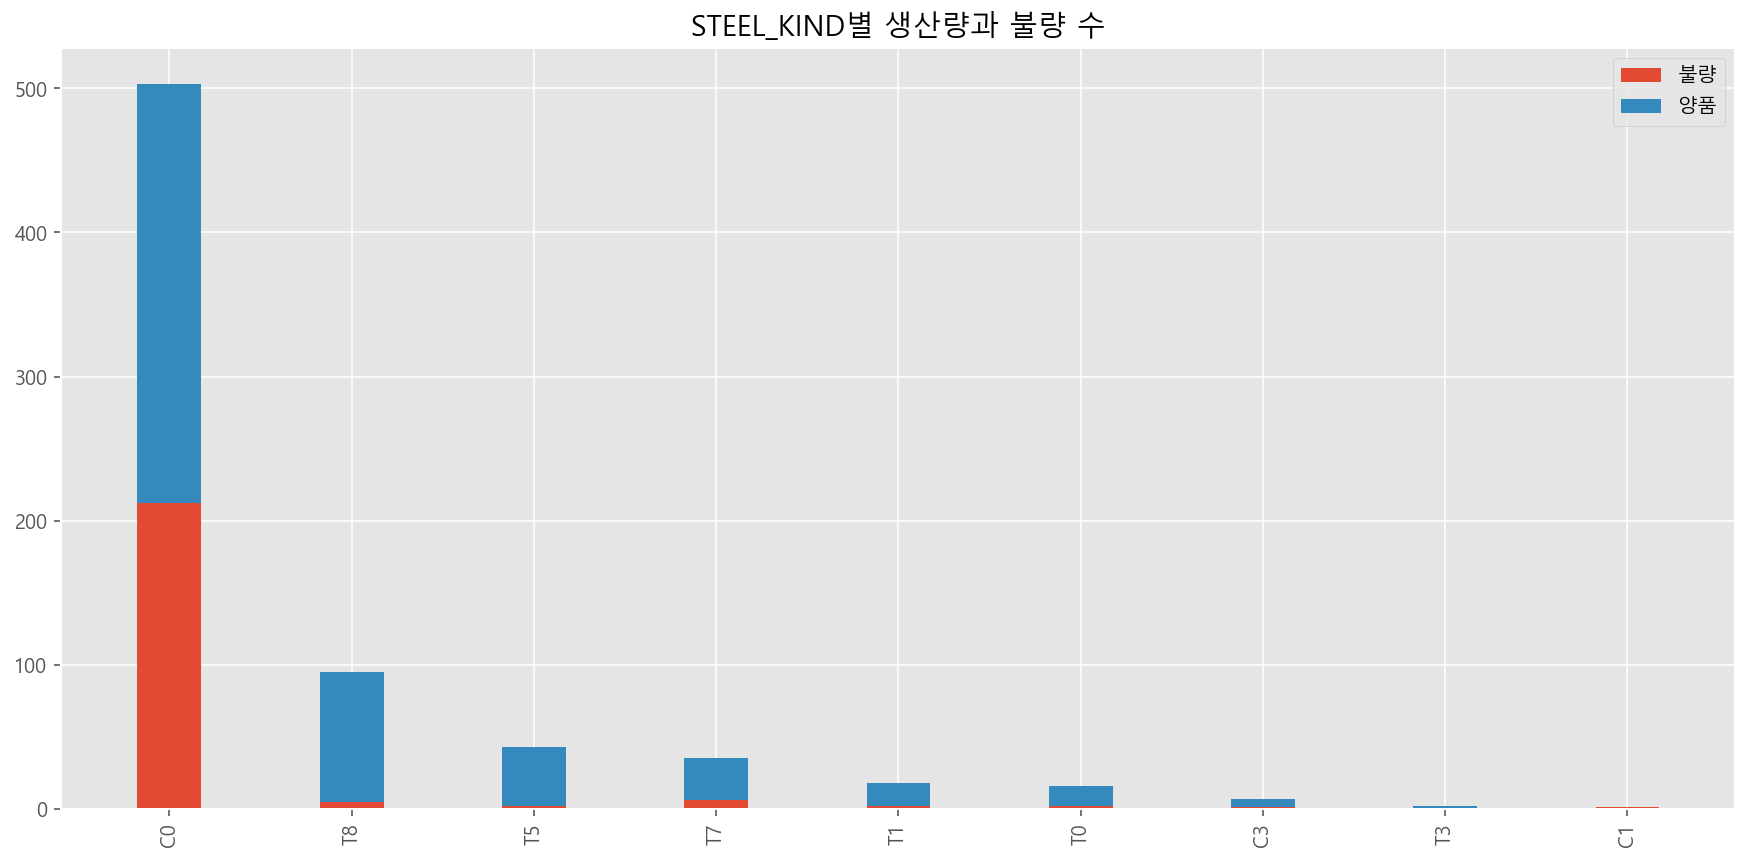

In [ ]:
#Stacked Bar 차트

labels = sk_2['sk_1']
x1 = sk_2['0']
x2 = sk_2['1']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(labels, x1, width, label='불량')
ax.bar(labels, x2, width, bottom=x1, label='양품')
#ax.set_xticklabels(labels, rotation=45)

#ax.set_ylabel('Scores')
ax.set_title('STEEL_KIND별 생산량과 불량 수')
ax.legend()

plt.style.use('ggplot')
#plt.figure(figsize=(15,7))
#plt.bar(bc1_labels, bc1_values, width=0.7)
#plt.set_xlabel(fontsize=10)
plt.xticks(rotation=90)
#plt.yticks(np.arange(0, 100, step=5))
#plt.margins(0.01)
plt.grid(True, axis='y')
plt.show()

- 위 그래프를 통해 대부분의 불량품은 C0에서 발생하는 것을 파악할 수 있다.
- C0로 만든 제품들을 추리고 그룹을 나눠 분석할 필요가 있음을 알 수 있다.
- C0와 아닌 것들을 묶어서 비교? (막대 or 파이차트)

In [51]:
main_02 = main_01[main_01['steel_kind'] == 'C0']
main_02['scale'].astype('category')

0      1
1      1
2      1
3      1
4      1
      ..
548    1
549    1
550    1
551    1
552    1
Name: scale, Length: 415, dtype: category
Categories (2, int64): [0, 1]

<AxesSubplot:xlabel='rolling_descaling', ylabel='count'>

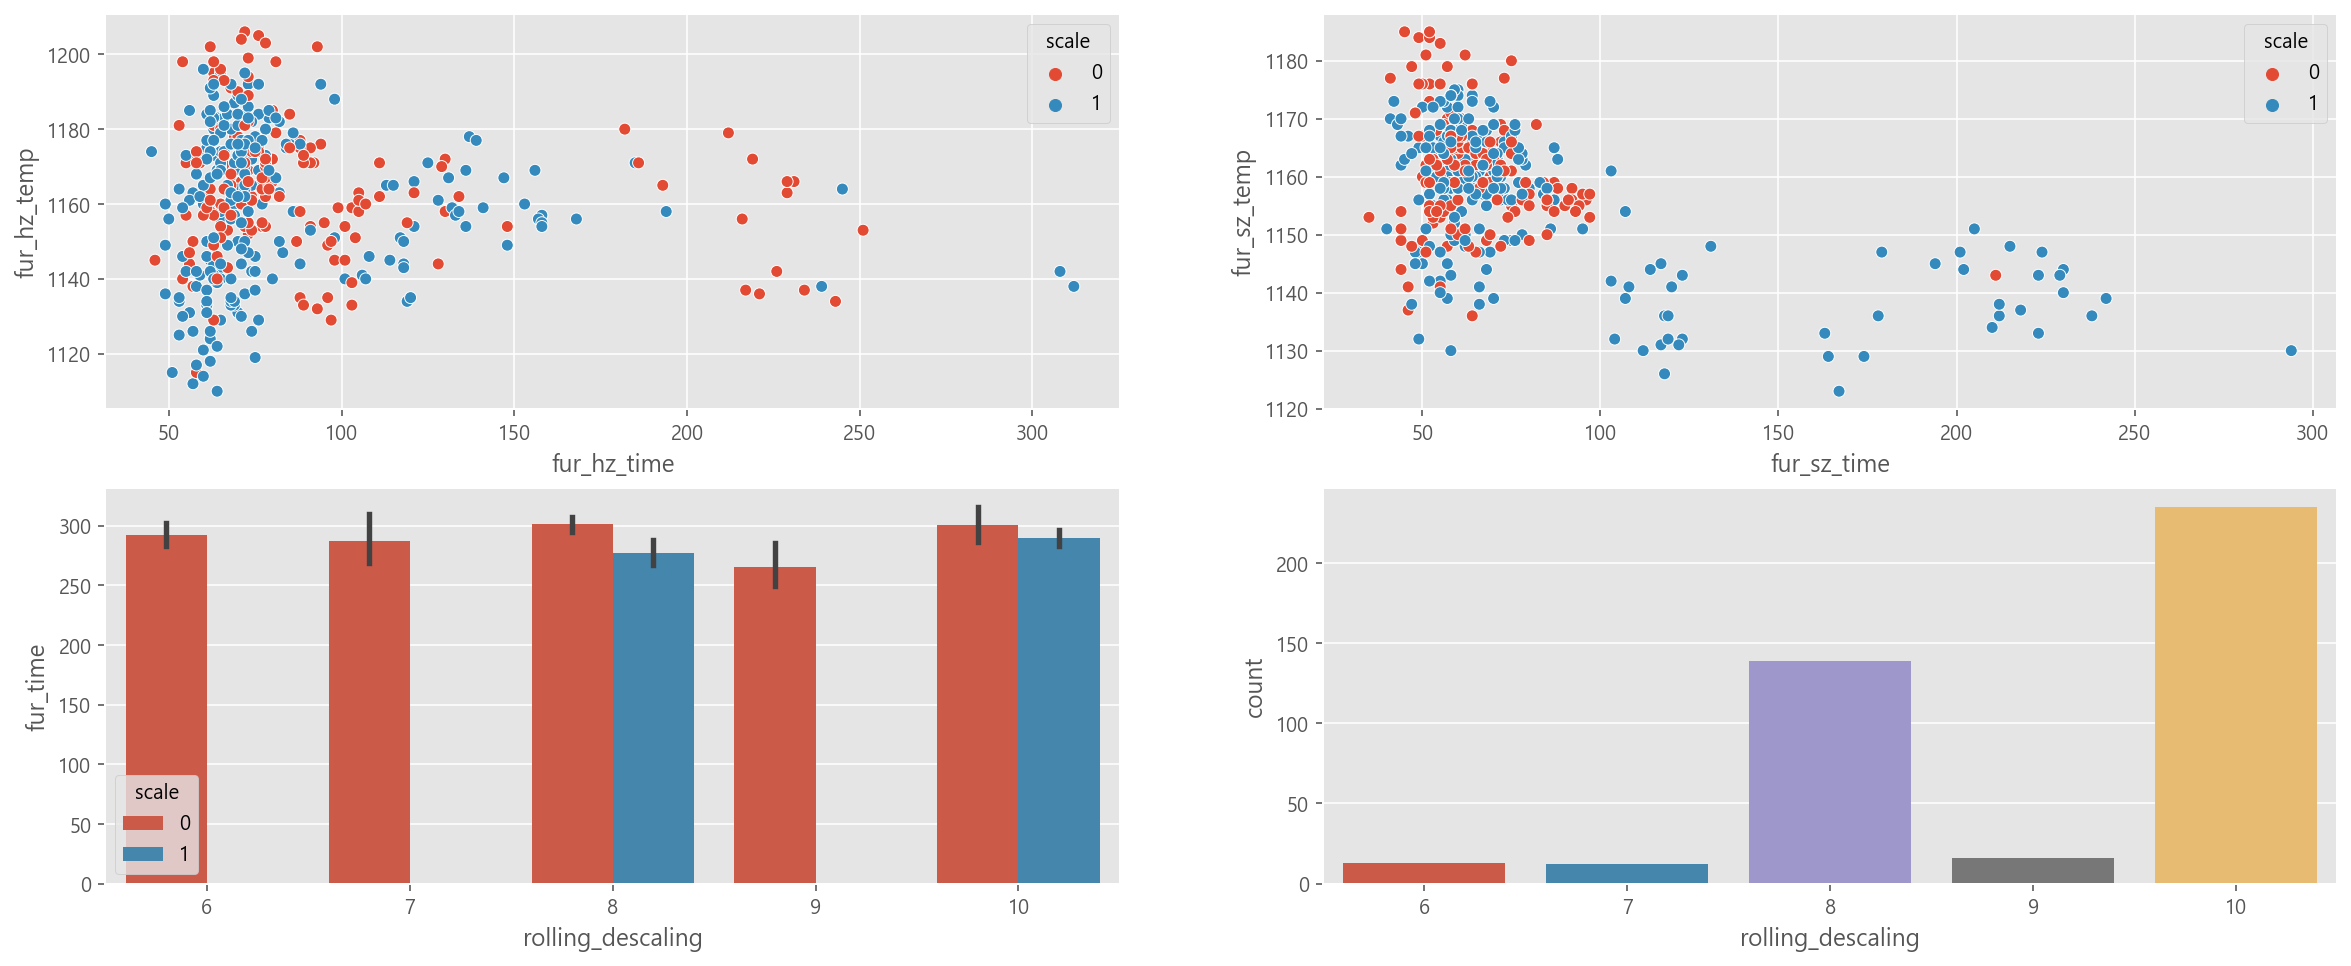

In [64]:
fig_02 = plt.figure(figsize=(20,8))
ax1 = fig_02.add_subplot(2,2,1)
ax2 = fig_02.add_subplot(2,2,2)
ax3 = fig_02.add_subplot(2,2,3)
ax4 = fig_02.add_subplot(2,2,4)

sns.scatterplot(data=main_02, x='fur_hz_time', y='fur_hz_temp', hue = 'scale', ax=ax1)
sns.scatterplot(data=main_02, x='fur_sz_time', y='fur_sz_temp', hue = 'scale', ax=ax2)
sns.barplot(data=main_02, x='rolling_descaling', y='fur_time', hue = 'scale', ax=ax3)
sns.countplot(data=main_02, x='rolling_descaling',  ax=ax4)


- 1번 그래프를 통해 fur hz에서 175분 이상 가열하지 않고 100분 이내 가열할 때 불량율을 낮출 수 있는 방법이 필요해 보인다.
- 1번 그래프를 통해 약 1130도 이하에서 작업하는 것이 불량품을 줄일 수 있을 것으로 보인다.
- 2번 그래프를 통해 fur sz에서 100~150분 사이에서 가열하는 것이 시간적, 비용적 가장 좋을 것으로 보인다.
- 2번 그래프를 통해 약 1140도 이하에서 작업하는 것이 불량품을 줄일 수 있을 것으로 보인다.
- 3번 그래프를 위 4가지 인사이트에 대한 근거로 볼 수 있다.
- ?온도와 시간 외의 변수를 생각해야한다 / 공장 입장에서 시간을 늘리는 게 쉽지않다
- 총 가열로 시간 - (sz+hz) = 새로운 time <- 분석
- time 100을 기준으로 분석?

In [ ]:
result = steel.groupby(['steel_kind','spec'], as_index=False).agg({'pt_thk': np.ptp, 'pt_wdth': np.ptp,
                                                   'pt_lth': np.ptp, 'pt_wgt': np.ptp
                                                   })
print(result.to_string())

   STEEL_KIND         SPEC  PT_THK  PT_WDTH  PT_LTH  PT_WGT
0          C0       A283-C    8.09      844   12163   42770
1          C0      A516-60    0.00        0       0       0
2          C0      A709-36    0.00        0       0       0
3          C0         AB/A   12.62     1193   13484   25890
4          C0      AB/AH32    3.53       43    4978   24720
5          C0         AB/B    6.07     1826   29771   53800
6          C0         BV-A    0.00        0       0       0
7          C0      BV-AH32    8.09     2488   30436   54480
8          C0         BV-B    5.06     1570   15231   70960
9          C0        CCS-B    0.00        0       0       0
10         C0         GL-A    1.01      749   14466   14140
11         C0       GL-A32    5.05      789   12175   57080
12         C0    JS-SM400A    0.00        0       0       0
13         C0    JS-SM400B    0.00        0       0       0
14         C0    JS-SM490A   37.11      925   35685   63120
15         C0   JS-SM490YA    0.00      

- SZ 가열로 온도와 가열로 추출온도가 완전히 같다 or 자료의 오류?

In [ ]:
# #SPEC별 

# bc1_labels = steel['spec'].unique()
# bc1_values = steel.groupby('spec')['scale'].count().sort_values(ascending=False)

# plt.figure(figsize=(15,7))
# plt.bar(bc1_labels, bc1_values, width=0.7)
# #plt.set_xlabel(fontsize=10)
# plt.xticks(rotation=90)
# plt.yticks(np.arange(0, 100, step=5))
# plt.margins(0 .01)
# plt.grid(True, axis='y')
# plt.show()